In [9]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


In [3]:
data = pd.read_csv('Airline-passengers.csv') 
data= data.dropna()
## convert no. of passengers to ln(no. of passengers) - model this "more stationary" series
data['lnair'] = np.log(data['Passengers'])

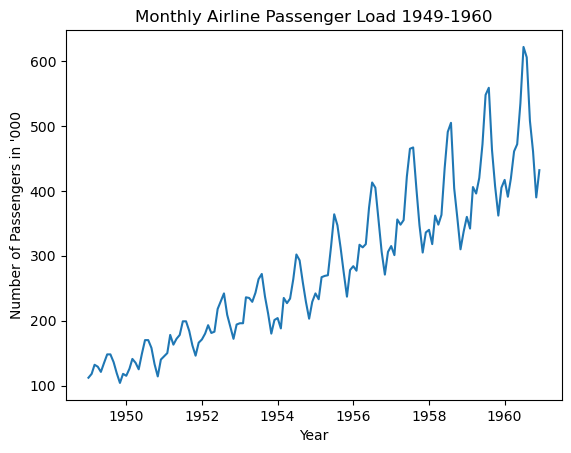

In [5]:
dataframe = pd.DataFrame(data,columns=['Month', 'Passengers'])
dataframe["Month"] = dataframe["Month"].astype("datetime64[ns]")
dataframe = dataframe.set_index("Month")
plt.plot(dataframe["Passengers"], marker='')

# Labelling 
plt.xlabel("Year")
plt.ylabel("Number of Passengers in '000")
plt.title("Monthly Airline Passenger Load 1949-1960")

# Display
plt.show()

# There appears to be a 12-month seasonality
- ywm
    - The method='ywm' parameter specifies the Yule-Walker method for estimating the PACF. The Yule-Walker method is one of several methods available for this purpose and is based on solving the Yule-Walker equations, which are a set of equations that provide estimates of autocorrelations for a stationary time series. Other methods may include ols (ordinary least squares), mle (maximum likelihood estimation), and more, depending on the function and library version.

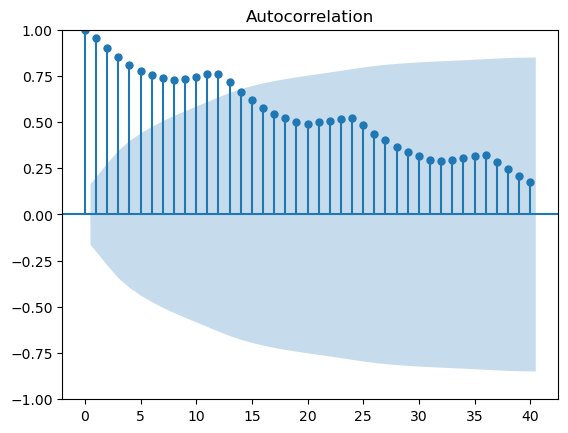

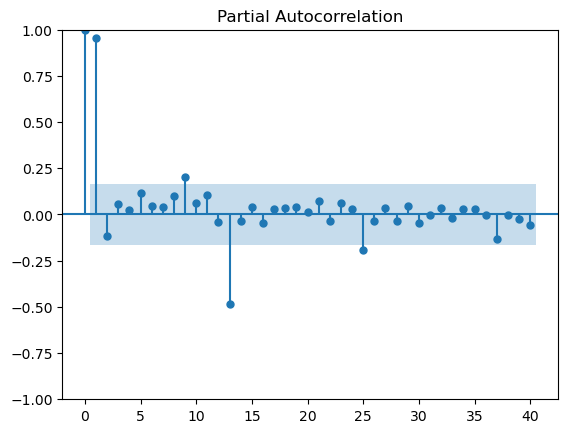

In [7]:
plot_acf(data['lnair'], lags=40);
plot_pacf(data['lnair'], method='ywm', lags=40);

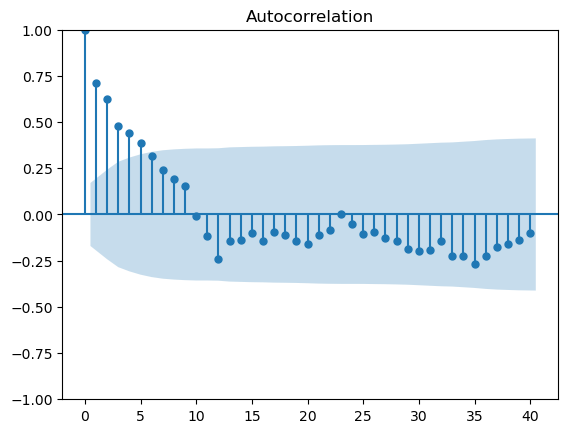

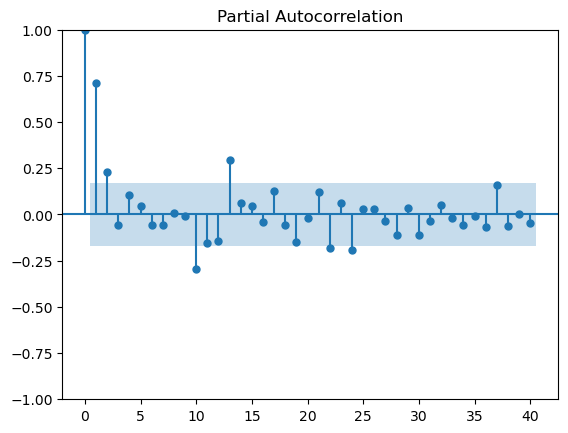

In [8]:
lnair12 = data['lnair']-data['lnair'].shift(12) ##.shift(12) means to subtract from 12 mths earlier
data['lnair12'] =lnair12 
lnair12 = data['lnair12'].dropna()
plot_acf(lnair12.dropna(), lags=40);
plot_pacf(lnair12.dropna(), method='ywm', lags=40);

In [10]:
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['10%']
    if (pvalue < 0.10) and (adf < critical_value):   ### and because statsmodel adfuller p-value is not as accurate
        print('The series is stationary, reject null at 10% significance level')
    else:
        print('The series is NOT stationary, do not reject null at 10% significance level')

In [12]:
print('ADF Statistic: %f' % adfuller(lnair12)[0])
print('p-value: %f' % adfuller(lnair12)[1])
check_stationarity(lnair12)

ADF Statistic: -2.709577
p-value: 0.072396
The series is stationary, reject null at 10% significance level


In [13]:
### Apply (1,0,1) x (0,1,0)_12 
import statsmodels.api as sm
model0 = sm.tsa.statespace.SARIMAX(data['lnair'], order=(1,0,1), seasonal_order=(0, 1, 0, 12))  
model0_fit=model0.fit(disp=0)
print(model0_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               lnair   No. Observations:                  144
Model:             SARIMAX(1, 0, 1)x(0, 1, [], 12)   Log Likelihood                 228.678
Date:                             Tue, 06 Feb 2024   AIC                           -451.355
Time:                                     19:31:26   BIC                           -442.707
Sample:                                          0   HQIC                          -447.841
                                             - 144                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9768      0.017     56.236      0.000       0.943       1.011
ma.L1         -0.3738      

In [14]:
model1 = sm.tsa.statespace.SARIMAX(data['lnair12'], trend='c', order=(1,0,1))  
model1_fit=model1.fit(disp=0)
print(model1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                lnair12   No. Observations:                  144
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 232.589
Date:                Tue, 06 Feb 2024   AIC                           -457.177
Time:                        19:32:19   BIC                           -445.298
Sample:                             0   HQIC                          -452.350
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0164      0.007      2.261      0.024       0.002       0.031
ar.L1          0.8569      0.057     15.035      0.000       0.745       0.969
ma.L1         -0.2848      0.103     -2.767      0.0

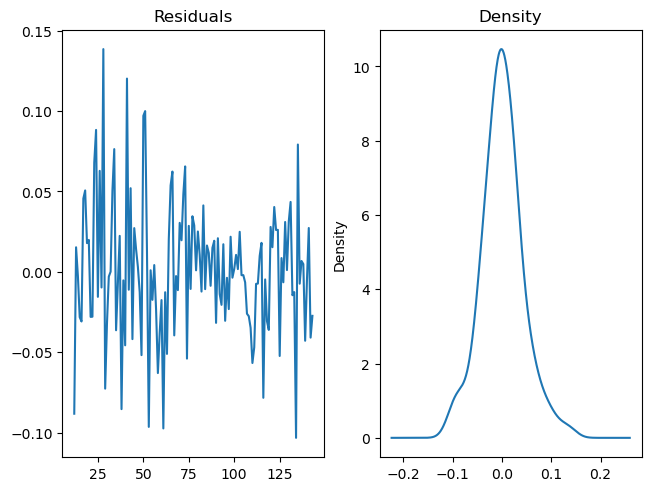

In [15]:
### Plot residual errors
residuals1 = model1_fit.resid
fig,ax = plt.subplots(1,2,constrained_layout = True)
residuals1.plot(title="Residuals", ax=ax[0])
residuals1.plot(kind='kde',title='Density',ax=ax[1])
plt.show()

In [16]:
predictions1 = model1.fit().predict()  ### Note: 'predict' is just fitting here
err1=abs(predictions1-lnair12.dropna())
err1na=err1.dropna()


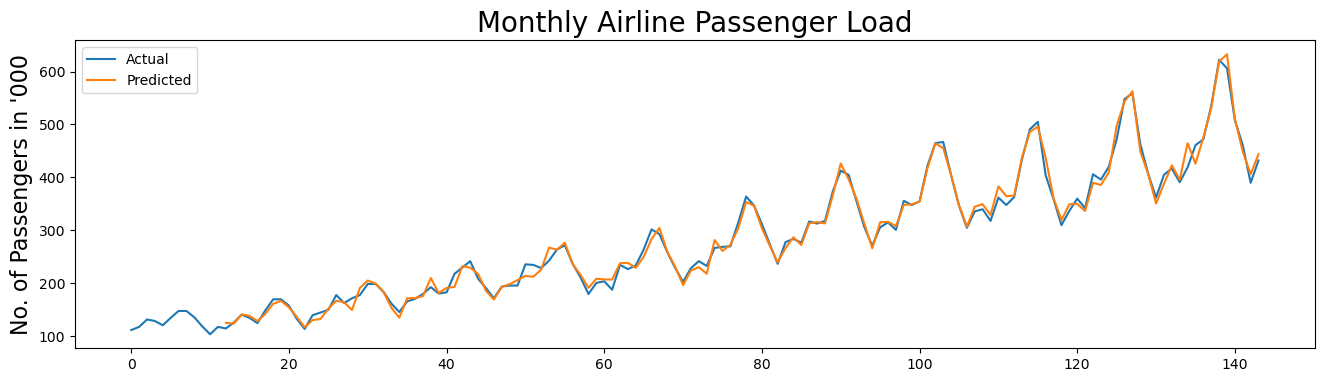

In [17]:
predict1=predictions1 + data['lnair'].shift(12)

## convert ln back to raw levels
Epredict1=np.exp(predict1)

plt.figure(figsize=(16,4))
plt.plot(data['Passengers'], label="Actual")
plt.plot(Epredict1, label="Predicted")
plt.title('Monthly Airline Passenger Load', fontsize=20)
plt.ylabel("No. of Passengers in '000", fontsize=16)
plt.legend()

# Try 1-month ahead prediction

When you set dynamic=True, the model continuously predicts one-step ahead (t+1) and then for the 2nd step ahead (t+2) prediction, it appends predicted value (t+1) to data, re-fits model on new expanded data then makes 2nd step ahead forecast. This is called out-of-sample prediction using predicted explanatory variables

When you set dynamic=False, the model sequentially predicts one-step-ahead using the true value from previous time step instead of using predicted value. This is called out-of-sample prediction using lagged explanatory variables

In [22]:
### Apply (1,0,6) directly to lnair12 -- avoid initial 12 obs null in fitting later
### Results slightly diff cos of 144 vs 132, treating of starting value
import statsmodels.api as sm
model2 = sm.tsa.statespace.SARIMAX(data['lnair12'], trend='c', order=(1,0,6))  
model2_fit=model2.fit(disp=0,maxiter=250)  ## incr maxiter avoids 'nonconverg of ML'
print(model2_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                lnair12   No. Observations:                  144
Model:               SARIMAX(1, 0, 6)   Log Likelihood                 238.866
Date:                Tue, 06 Feb 2024   AIC                           -459.732
Time:                        19:49:53   BIC                           -433.003
Sample:                             0   HQIC                          -448.871
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0253      0.011      2.220      0.026       0.003       0.048
ar.L1          0.7776      0.084      9.211      0.000       0.612       0.943
ma.L1         -0.2522      0.105     -2.411      0.0

In [23]:
predictions2 = model2.fit().predict()  ### Note: 'predict' is just fitting here
pd.set_option('display.max_rows', None)  ### print without truncation
print(predictions2)
err2=abs(predictions2-lnair12.dropna())
print(err2.dropna())
err2na=err2.dropna()
print("mean abs error =", np.sum(err2na)/err2na.size)

0      0.113851
1      0.113851
2      0.113851
3      0.113851
4      0.113851
5      0.113851
6      0.113851
7      0.113851
8      0.113851
9      0.113851
10     0.113851
11     0.113851
12     0.113851
13     0.050689
14     0.067921
15     0.078988
16     0.054665
17     0.042995
18     0.085125
19     0.134918
20     0.125426
21     0.119691
22     0.121140
23     0.122628
24     0.160576
25     0.203250
26     0.173171
27     0.170231
28     0.181729
29     0.255252
30     0.215890
31     0.129625
32     0.173038
33     0.186254
34     0.193386
35     0.175270
36     0.149326
37     0.144999
38     0.158145
39     0.121894
40     0.110854
41     0.099365
42     0.160442
43     0.160678
44     0.119556
45     0.121111
46     0.139254
47     0.181472
48     0.149547
49     0.140806
50     0.118701
51     0.171564
52     0.227477
53     0.184289
54     0.103160
55     0.115430
56     0.173395
57     0.151908
58     0.096528
59     0.057427
60     0.069720
61     0.059958
62    -0

C:\adam\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


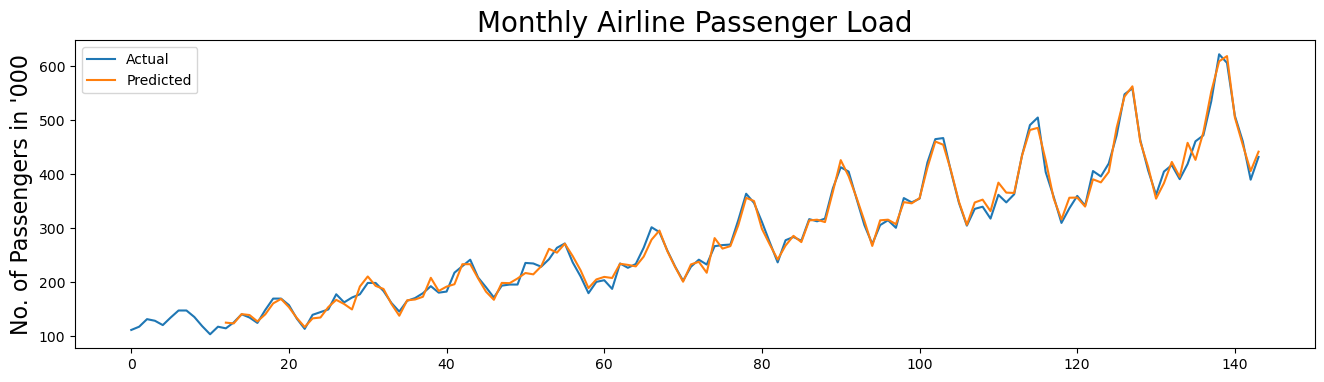

In [24]:
predict2=predictions2 + data['lnair'].shift(12)
## convert ln back to raw levels
Epredict2=np.exp(predict2)
plt.figure(figsize=(16,4))
plt.plot(data['Passengers'], label="Actual")
plt.plot(Epredict2, label="Predicted")
plt.title('Monthly Airline Passenger Load', fontsize=20)
plt.ylabel("No. of Passengers in '000", fontsize=16)
plt.legend()

In [25]:
s=model2_fit.predict(start=0, end=150, exog=None, dynamic=False)
print(s)

0      0.113897
1      0.113897
2      0.113897
3      0.113897
4      0.113897
5      0.113897
6      0.113897
7      0.113897
8      0.113897
9      0.113897
10     0.113897
11     0.113897
12     0.113897
13     0.049831
14     0.067189
15     0.078526
16     0.054259
17     0.042282
18     0.084800
19     0.135029
20     0.125597
21     0.119558
22     0.121166
23     0.122403
24     0.160479
25     0.204387
26     0.174342
27     0.170766
28     0.182926
29     0.256452
30     0.217070
31     0.129926
32     0.172628
33     0.187587
34     0.193751
35     0.176666
36     0.150851
37     0.145114
38     0.158584
39     0.122027
40     0.109850
41     0.098878
42     0.160514
43     0.161488
44     0.120349
45     0.121170
46     0.139911
47     0.181353
48     0.149959
49     0.140569
50     0.118651
51     0.171849
52     0.228892
53     0.186172
54     0.103310
55     0.115360
56     0.173650
57     0.152027
58     0.096262
59     0.057379
60     0.069285
61     0.059795
62    -0

# diff between 2 predictions

In [26]:
s=model2_fit.predict(start=0, end=150, exog=None, dynamic=False)
print(s)

0      0.113897
1      0.113897
2      0.113897
3      0.113897
4      0.113897
5      0.113897
6      0.113897
7      0.113897
8      0.113897
9      0.113897
10     0.113897
11     0.113897
12     0.113897
13     0.049831
14     0.067189
15     0.078526
16     0.054259
17     0.042282
18     0.084800
19     0.135029
20     0.125597
21     0.119558
22     0.121166
23     0.122403
24     0.160479
25     0.204387
26     0.174342
27     0.170766
28     0.182926
29     0.256452
30     0.217070
31     0.129926
32     0.172628
33     0.187587
34     0.193751
35     0.176666
36     0.150851
37     0.145114
38     0.158584
39     0.122027
40     0.109850
41     0.098878
42     0.160514
43     0.161488
44     0.120349
45     0.121170
46     0.139911
47     0.181353
48     0.149959
49     0.140569
50     0.118651
51     0.171849
52     0.228892
53     0.186172
54     0.103310
55     0.115360
56     0.173650
57     0.152027
58     0.096262
59     0.057379
60     0.069285
61     0.059795
62    -0